## 1. Scrap API with fsspec, s3 & zarr stores.

We are searching for the group EFM.

Variables: fwtmp, magpr_ang, magpr_len, magpr_r, magpr_z, magpr_x, magpr_c


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import fsspec

from pathlib import Path

In [5]:
shots_df = pd.read_parquet(f'https://mastapp.site/parquet/level2/shots')
shot_list = shots_df['shot_id'].tolist()

In [6]:
np.random.seed(42)
selected_shots = np.random.choice(shot_list, size=5, replace=False)
print(selected_shots)

[20490 17778 23346 22999 21266]


In [7]:
class ShotLoader:
    def __init__(self, cache_dir=".cache"):
        self.endpoint_url = "https://s3.echo.stfc.ac.uk"
        self.url_template = "s3://mast/level1/shots/{shot}.zarr"
        self.cache_dir = cache_dir

        self.fs = fsspec.filesystem(
            "simplecache",
            target_protocol="s3",
            cache_storage=cache_dir,
            target_options={'anon': True, 'endpoint_url': self.endpoint_url},
        )

    def load(self, shot: int, group: str) -> xr.Dataset:
        url = self.url_template.format(shot=shot)
        mapper = self.fs.get_mapper(url)
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, module="zarr")
            dataset = xr.open_zarr(mapper, group=group)
        return dataset
shotloader = ShotLoader()

### A. Magnetic probes position

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [9]:
efm_data = shotloader.load(selected_shots[0], "efm")
prob_r = efm_data.magpr_r.values
prob_z = efm_data.magpr_z.values
prob_len = efm_data.magpr_len.values
prob_ang = efm_data.magpr_ang.values
efm_data.fwtmp.values

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [10]:
def plot_magnetic_probes(efm_data, shot_id):
    prob_r = efm_data.magpr_r.values
    prob_z = efm_data.magpr_z.values
    prob_length = efm_data.magpr_len.values
    prob_ang = efm_data.magpr_ang.values
    
    n_probes = len(prob_r)
    
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(f'Mag Probes position - Shot {shot_id}', fontsize=16)
    
    # 1. Vue en plan (R-Z)
    ax1 = fig.add_subplot(121)
    ax1.set_title('Plan View (R-Z)')
    ax1.set_xlabel('R [m]')
    ax1.set_ylabel('Z [m]')
    ax1.grid(True)
    
    # Taille des points proportionnelle à la longueur des probes
    sizes = 100 * prob_length / np.max(prob_length)  # Normalisation pour une meilleure visualisation
    
    # Affichage des points dans le plan R-Z
    scatter = ax1.scatter(prob_r, prob_z, s=sizes, alpha=0.7, c=prob_length, cmap='viridis')
    
    # Ajout d'une colorbar pour la longueur
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Probe Length [m]')
    
    # Annotation des points avec les numéros de probe
    for i, (r, z) in enumerate(zip(prob_r, prob_z)):
        ax1.annotate(str(i), (r, z), xytext=(5, 5), textcoords='offset points')
    
    # 2. Vue 3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('3D View with Orientations')
    ax2.set_xlabel('X [m]')
    ax2.set_ylabel('Y [m]')
    ax2.set_zlabel('Z [m]')
    
    # Calcul des positions 3D (fixer phi=0 pour toutes les probes)
    x_pos = prob_r
    y_pos = np.zeros_like(prob_r)
    z_pos = prob_z
    
    ax2.scatter(x_pos, y_pos, z_pos, s=sizes, alpha=0.7, c=prob_length, cmap='viridis')
    arrow_length = 0.1
    
    for i, (r, z, ang) in enumerate(zip(prob_r, prob_z, prob_ang)):
        ang = np.deg2rad(ang)
        dx = arrow_length * np.cos(ang)
        dy = 0
        dz = arrow_length * np.sin(ang)
        
        ax2.quiver(r, 0, z, dx, dy, dz, color='red', length=arrow_length, normalize=True)
        ax2.text(r, 0, z, str(i), color='black')
    
    ax2.view_init(elev=20, azim=-60)
    
    plt.tight_layout()
    plt.show()

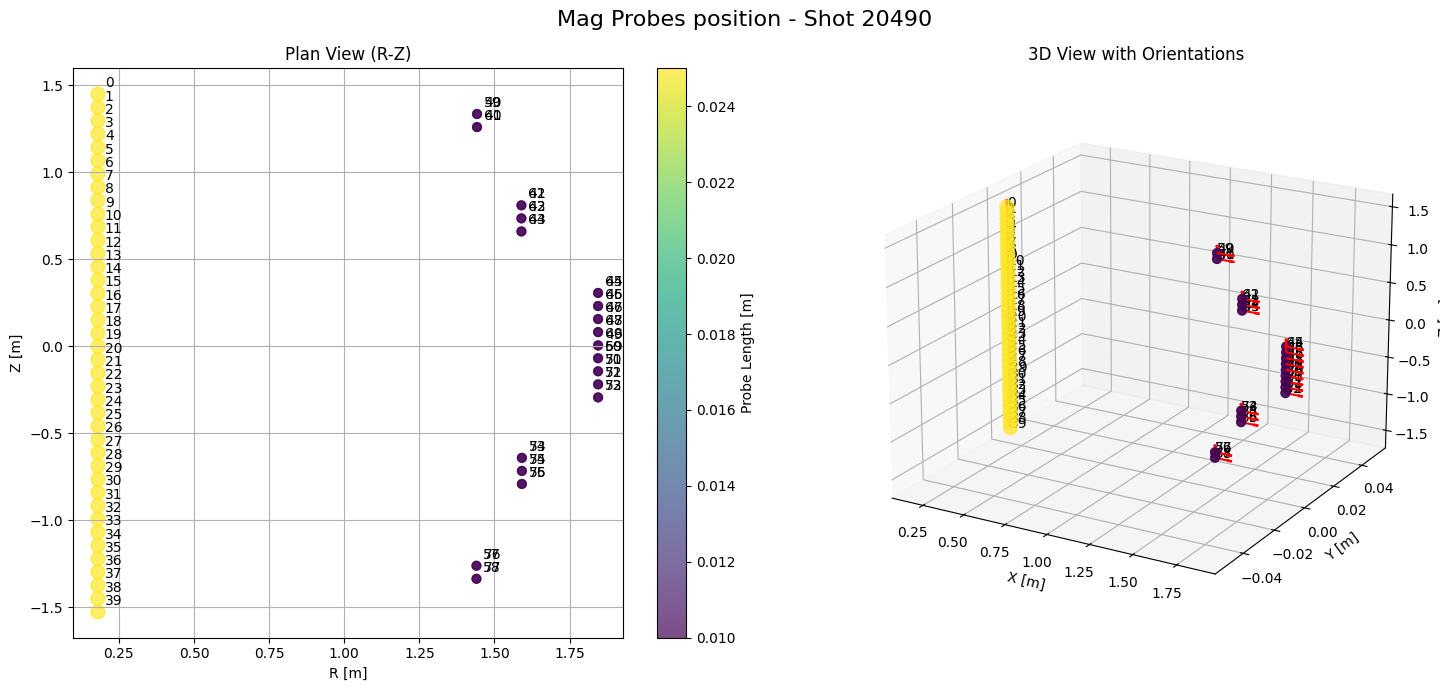

In [11]:
efm_data = shotloader.load(selected_shots[0], "efm")
plot_magnetic_probes(efm_data, selected_shots[0])

In [ ]:
path = Path().absolute().parent / "result_files/efit_analysis/coils_in_3d.png"
plt.savefig(path)

<Figure size 640x480 with 0 Axes>

### B. Presence of variable fwtmp? + nan proportion

In [12]:
import pandas as pd
import tqdm
from concurrent.futures import as_completed, ThreadPoolExecutor
from functools import partial

import os
import time
import psutil

In [13]:
def to_dask(shot: int, group: str = "efm", level: int = 1) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from (default is "efm").
    level: Data level to retrieve (default is 1).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [14]:
def retry_to_dask(shot_id, group, level, retries=5, delay=0.5, verbose=True):
    """
    Retry loading a shot's data as a Dask Dataset with exponential backoff.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Level of data to retrieve.
    retries: Number of retry attempts (default is 3).
    delay: Delay in seconds between retries (default is 5).

    Returns
    xr.Dataset
        The Dask Dataset for the specified shot and group.
    or Error
    """
    for attempt in range(retries):
        try:
            return to_dask(shot_id, group, level)
        except Exception as e:
            if attempt < retries - 1:
                if verbose:
                    print(f"Retrying connection to {shot_id} in group {group} (attempt {attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                raise e

In [15]:
def get_optimal_workers(task_type="cpu"):
    """
    Get the optimal number of workers for parallel processing based on the task type.

    Parameters
    task_type: str
        Type of task to determine the optimal number of workers (possible: "cpu", or "gpu").

    Returns the optimal number of workers based on the task type.
    """
    cpu_logical = os.cpu_count()
    
    if task_type == "gpu":
        try:
            import torch
            if torch.cuda.is_available():
                return torch.cuda.device_count()
            else:
                return 0
        except ImportError:
            return 0
    elif task_type == "cpu":
        try:
            return psutil.cpu_count(logical=False)
        except:
            return max(1, cpu_logical // 2)  # Default to half of logical cores
    else:
        return max(1, cpu_logical - 1) # Default to one less than logical cores
    

In [16]:
def process_shot(shot_id, verbose=False):
    """
    Process a single shot, returning a dictionary of results.

    Parameters
    shot_id: Shot ID to retrieve data for.
    verbose: bool
        Displays messages for debugging or tracking.
    
    Returns
    shot_id: int
        The shot ID processed.
    shot_result: dict
        Dictionary containing the presence of variables and their channels:
    """
    try:
        efm = retry_to_dask(shot_id, group="efm", level=1, verbose=verbose)
        try:
            fwtmp = efm.fwtmp.values
            if np.all(np.isnan(fwtmp)):
                code = 101
            elif np.any(np.isnan(fwtmp)):
                code = 102
            else:
                aggerated = np.mean(fwtmp, axis=0)
                ratio = int(np.sum(aggerated == 1.0) / len(aggerated) * 100)
                code = ratio
        except AttributeError:
            if verbose:
                print(f"No fwtmp data for shot {shot_id}")
            code = 0
            fwtmp = None
    except Exception as e:
        if verbose:
            print(f"Error loading efm data for shot {shot_id}: {e}")
        code = 0
        fwtmp = None
        
    result = {
        "shot_id": shot_id,
        "code": code,
        "fwtmp": fwtmp
    }
    if verbose:
        print(f"Processed shot {shot_id} with code {code}")
    return result



In [17]:
def efit_analysis_parallel(
    shots: list[int],
    verbose: bool = False,
    max_workers: int = None,
    task_type: str = "cpu"
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers(task_type=task_type)
    print(f"Use of {max_workers} workers (type: {task_type})")

    data_efit = {}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_result = future.result()
            data_efit[shot_result["shot_id"]] = shot_result["code"]

    df = pd.DataFrame.from_dict(data_efit, orient="index", columns=["code"])
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [ ]:
variable_presence_all = efit_analysis_parallel(
    shots=shot_list, 
    verbose=False,
    max_workers=None,
    task_type="cpu"
)

Use of 16 workers (type: cpu)


Checking variables (parallel):   0%|          | 0/11573 [00:01<?, ?it/s]


In [42]:
print(f"{'Code':<30} {'Count':<25}")
codes = [0, 101, 102] + list(range(1, 101))
tot = 0
for code in codes:
    subset = variable_presence_all[variable_presence_all['code'] == code]
    count = len(subset)
    print(f"{code:<30} {count:<25}")
    tot += count
print(f"\n{'Total':<30} {tot:<25}")

Code                           Count                    
0                              791                      
101                            0                        
102                            1                        
1                              0                        
2                              0                        
3                              0                        
4                              0                        
5                              0                        
6                              0                        
7                              0                        
8                              0                        
9                              0                        
10                             0                        
11                             0                        
12                             0                        
13                             0                        
14                             

In [18]:
path = Path().absolute().parent / "result_files/efit_analysis" / "efit_analysis.csv"
#path.parent.mkdir(parents=True, exist_ok=True)
#variable_presence_all.to_csv(path)

In [19]:
variable_presence_all = pd.read_csv(path, index_col=0)
variable_presence_all

,code
11768,0
11789,0
11775,0
11769,0
11777,0
...,...
30468,44
30469,44
30467,44
30471,44


In [20]:
mask1 = variable_presence_all['code']<=100
mask2 = variable_presence_all['code']>0
mask = mask1 & mask2

shots_with_fwtmp = variable_presence_all[mask].index.tolist()
shots_with_fwtmp

[11876,
 12127,
 12034,
 12128,
 12063,
 12077,
 12076,
 12065,
 12069,
 12075,
 12129,
 13207,
 12122,
 12123,
 12126,
 12125,
 12130,
 12139,
 12140,
 12141,
 12142,
 12146,
 12143,
 12144,
 12145,
 12151,
 12153,
 12150,
 12152,
 12148,
 12147,
 12158,
 12154,
 12161,
 12162,
 12165,
 12163,
 12164,
 12166,
 12167,
 12171,
 12170,
 12168,
 12169,
 12172,
 12173,
 12174,
 12177,
 12178,
 12183,
 12181,
 12179,
 12180,
 12182,
 12184,
 12175,
 12190,
 12189,
 12191,
 12185,
 12192,
 12193,
 12194,
 12200,
 12198,
 12199,
 12195,
 12203,
 12204,
 12196,
 12202,
 12201,
 12208,
 12209,
 12210,
 12213,
 12214,
 12215,
 12216,
 12218,
 12223,
 12229,
 12219,
 12221,
 12228,
 12224,
 12220,
 12230,
 12233,
 12232,
 12231,
 12234,
 12236,
 12237,
 12241,
 12245,
 12242,
 12243,
 12244,
 12246,
 12248,
 12252,
 12247,
 12253,
 12250,
 12254,
 12255,
 12256,
 12257,
 12259,
 12258,
 12260,
 12261,
 12262,
 12264,
 12263,
 12267,
 12268,
 12266,
 12269,
 12272,
 12270,
 12275,
 12278,
 12279,


### C. Visualization of fwtmp andcomarison with ip

In [38]:
from matplotlib.patches import Patch, Rectangle

In [46]:
def plot_fwtmp_vs_ip(shot_id, save: bool = False):
    try:
        efm = retry_to_dask(shot_id, group="efm", level=1, verbose=False)
        fwtmp = efm.fwtmp.values
        fwtmp_time = efm.time.values
        summary = retry_to_dask(shot_id, group="summary", level=2, verbose=False)
        ip = summary.ip.values
        ip_time = summary.time.values
    except Exception as e:
        print(f"Error loading data for shot {shot_id}: {e}")
        return

    # Création de la figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    max_ip, min_ip = np.nanmax(ip), np.nanmin(ip)
    ax.plot(ip_time, ip, label='Plasma Current (ip)', color='black')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Plasma Current (ip) [A]', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    # Déterminer les limites temporelles et les canaux
    n_channels = fwtmp.shape[1]  # Nombre de canaux (78)
    time_intervals = np.diff(fwtmp_time)
    
    # Pour chaque canal et chaque intervalle de temps
    for i in range(len(fwtmp_time) - 1):
        for j in range(n_channels):
            # Déterminer la couleur en fonction de la valeur fwtmp
            val = fwtmp[i, j]
            color = 'green' if val == 1.0 else ('red' if val == 0.0 else 'orange')

            x = fwtmp_time[i]
            y = j/n_channels*(max_ip-min_ip)+min_ip
            width = time_intervals[i]
            height = 1/n_channels*(max_ip-min_ip)
            
            # Créer un rectangle pour ce canal à cet intervalle de temps
            rect = Rectangle(
                (x, y),  # Position (x, y)
                width,              # Largeur
                height,           # Hauteur
                facecolor=color, 
                alpha=0.2,
                edgecolor='none',
                linewidth=0
            )
            ax.add_patch(rect)
            if i == 0 or fwtmp[i, j] != fwtmp[i-1, j]:
                # Ligne du bas - seulement si changement de valeur ou premier point
                ax.hlines(y, x, x + width, colors='black', linewidth=1., alpha=0.6)
            
            # Ligne du haut
            ax.hlines(y + height, x, x + width, colors='black', linewidth=1., alpha=0.6)
        ax.vlines(x, min_ip, max_ip, colors='black', linewidth=0.5, alpha=0.1)

    
    
    # Ajuster les limites de l'axe y pour voir tous les canaux
    #ax.set_ylim(bottom=0, top=1)
    
    # Ajouter une deuxième échelle y pour les canaux
    ax2 = ax.twinx()
    ax2.set_ylim(0, n_channels)
    ax2.set_ylabel('Channel Number', rotation=270, labelpad=15)

    # Ajouter une légende pour les couleurs
    
    legend_elements = [
        Patch(facecolor='black', alpha=1, label='Plasma Current (ip)'),
        Patch(facecolor='green', alpha=0.5, label='fwtmp = 1.0'),
        Patch(facecolor='red', alpha=0.5, label='fwtmp = 0.0'),
        Patch(facecolor='orange', alpha=0.5, label='Other values')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.title(f'Shot {shot_id}: fwtmp Channels vs Plasma Current (ip)')
    plt.tight_layout()
    if save:
        path = Path().absolute().parent / "result_files/efit_analysis/efit_weights_channels.png"
        plt.savefig(path, dpi=300)
    plt.show()

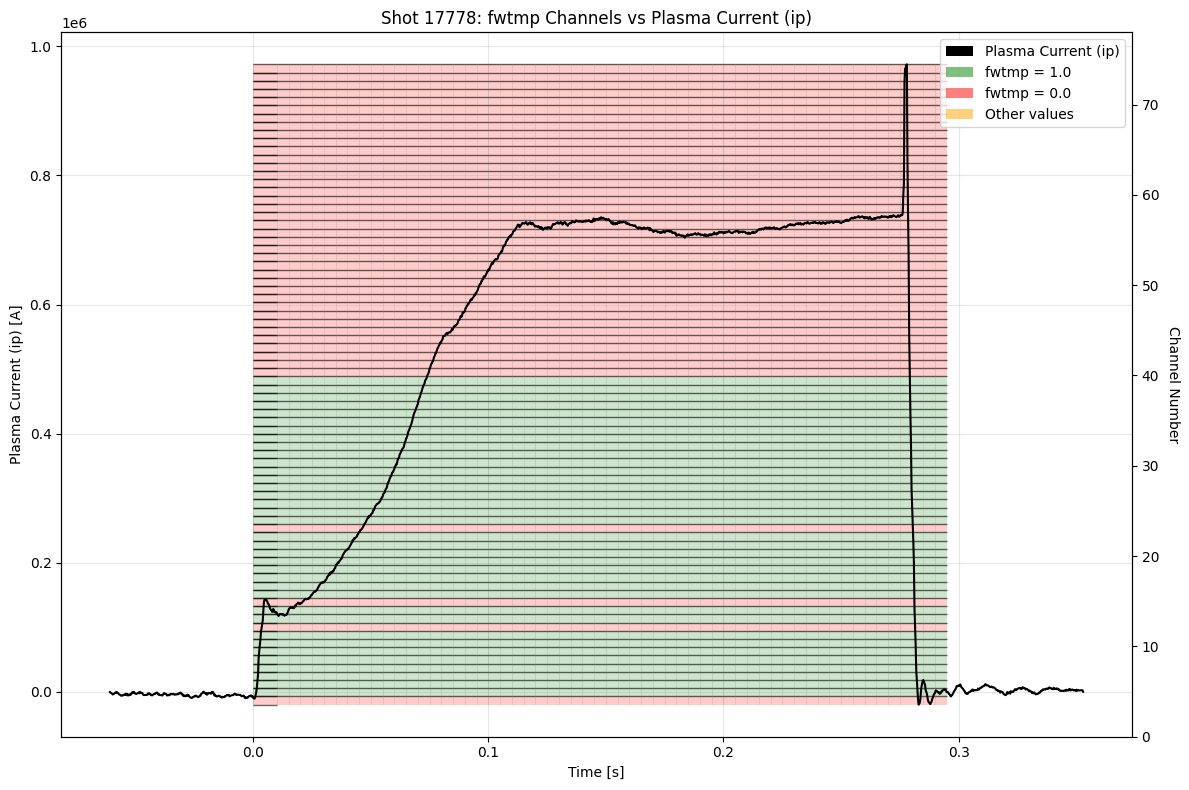

In [45]:
fig = plot_fwtmp_vs_ip(selected_shots[1], save=True)

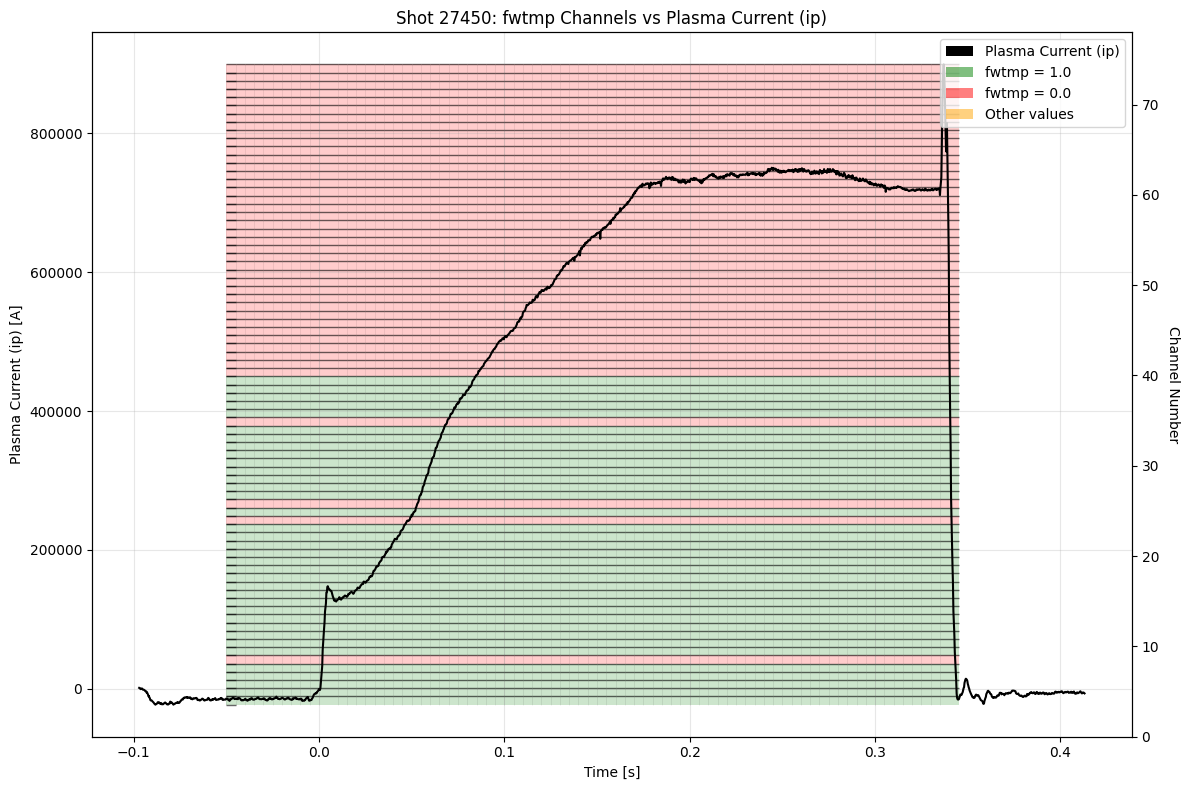

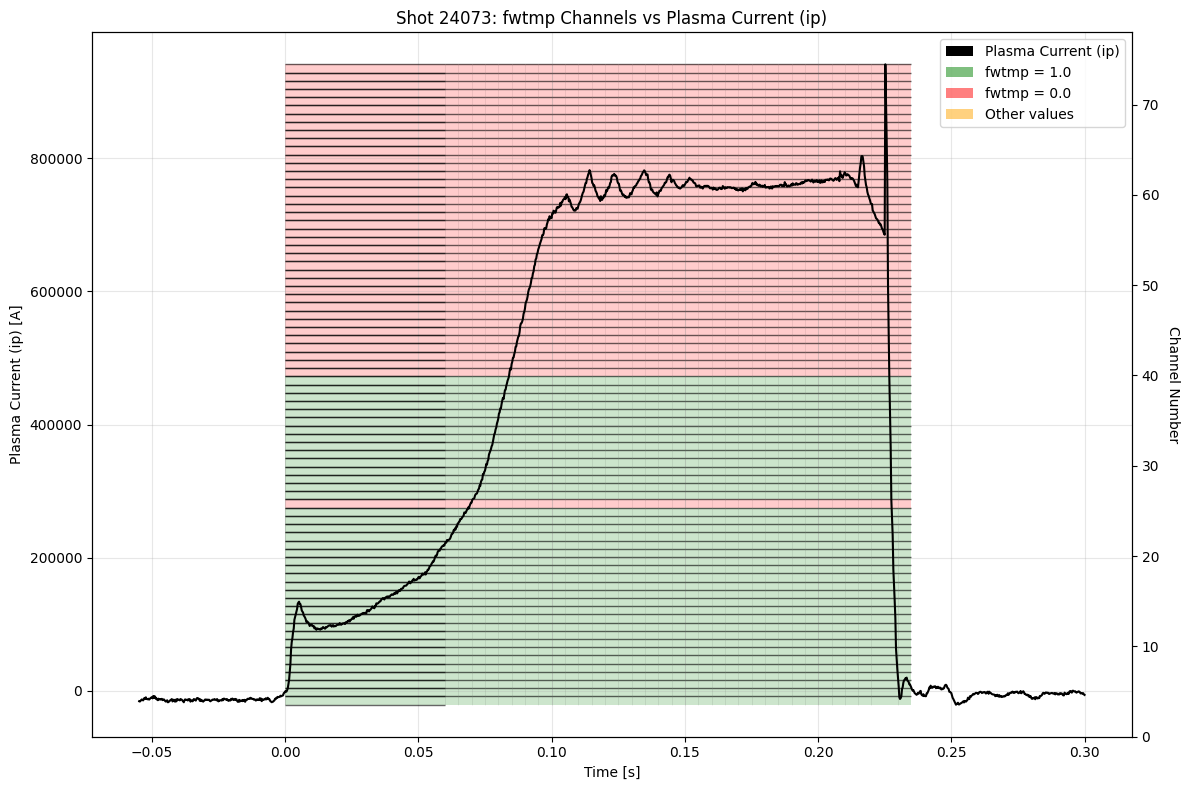

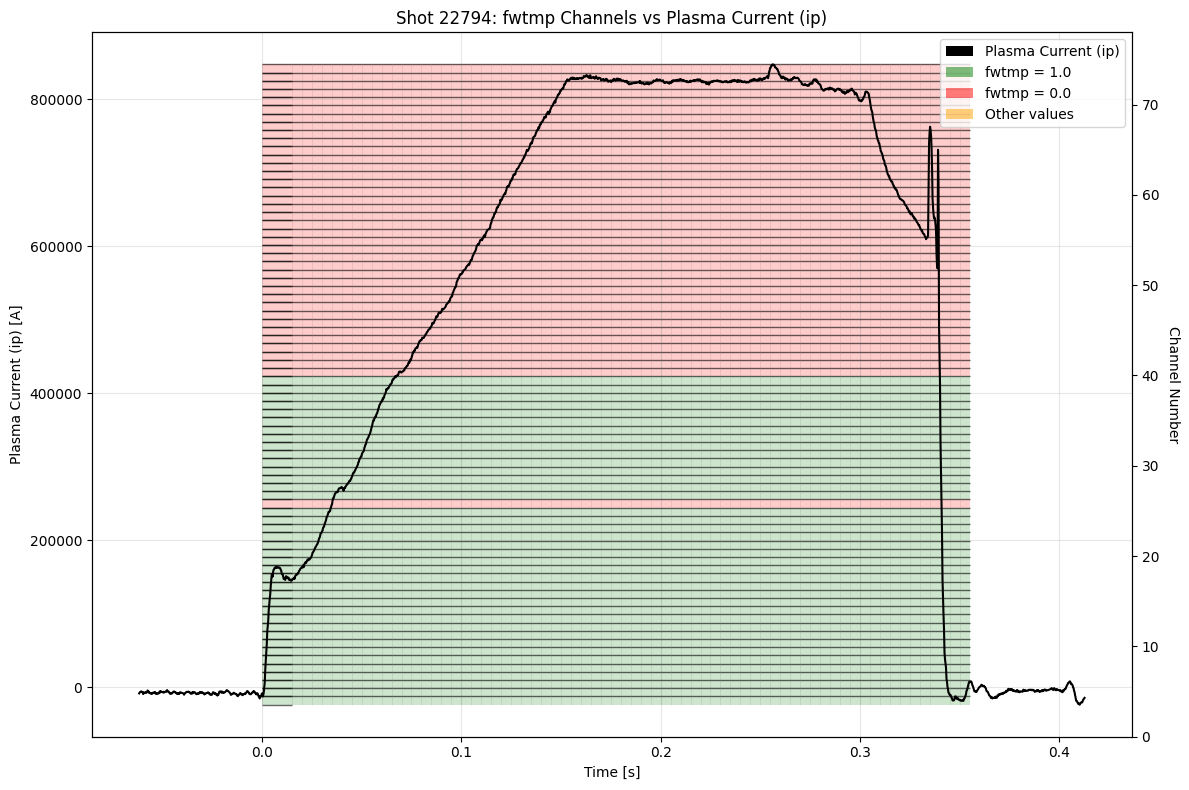

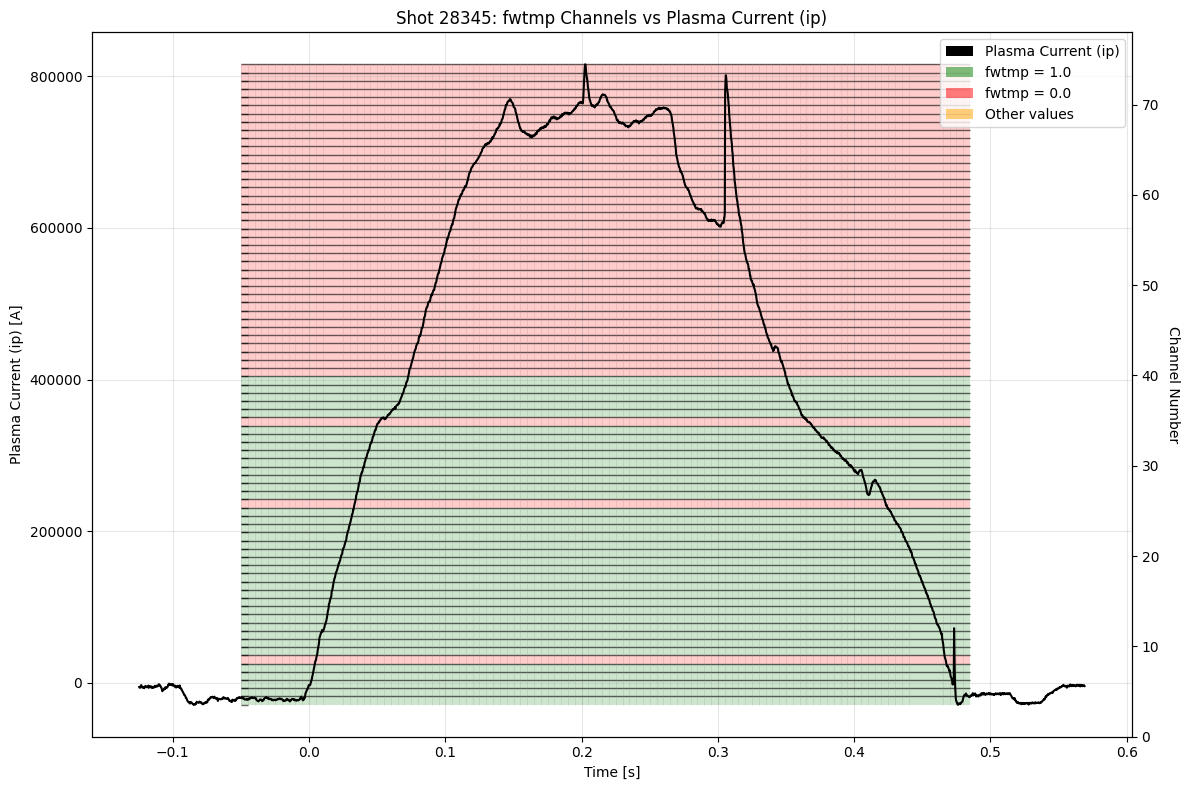

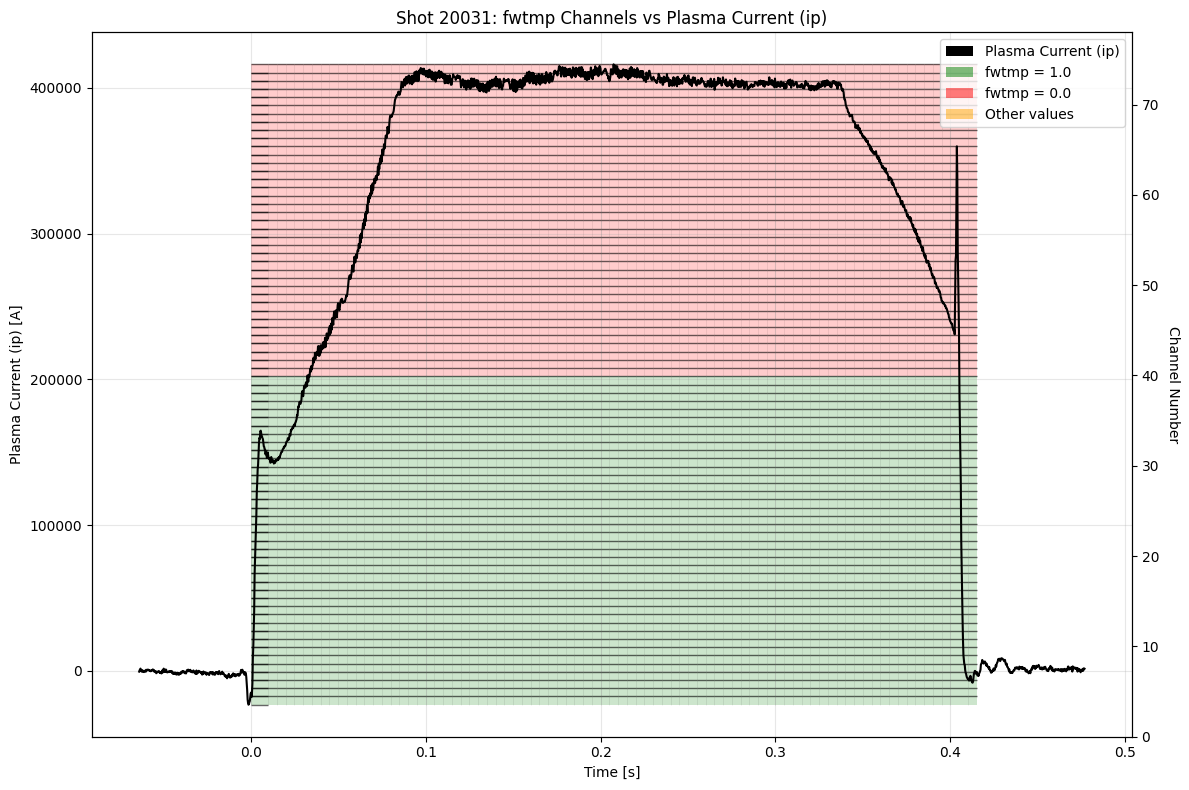

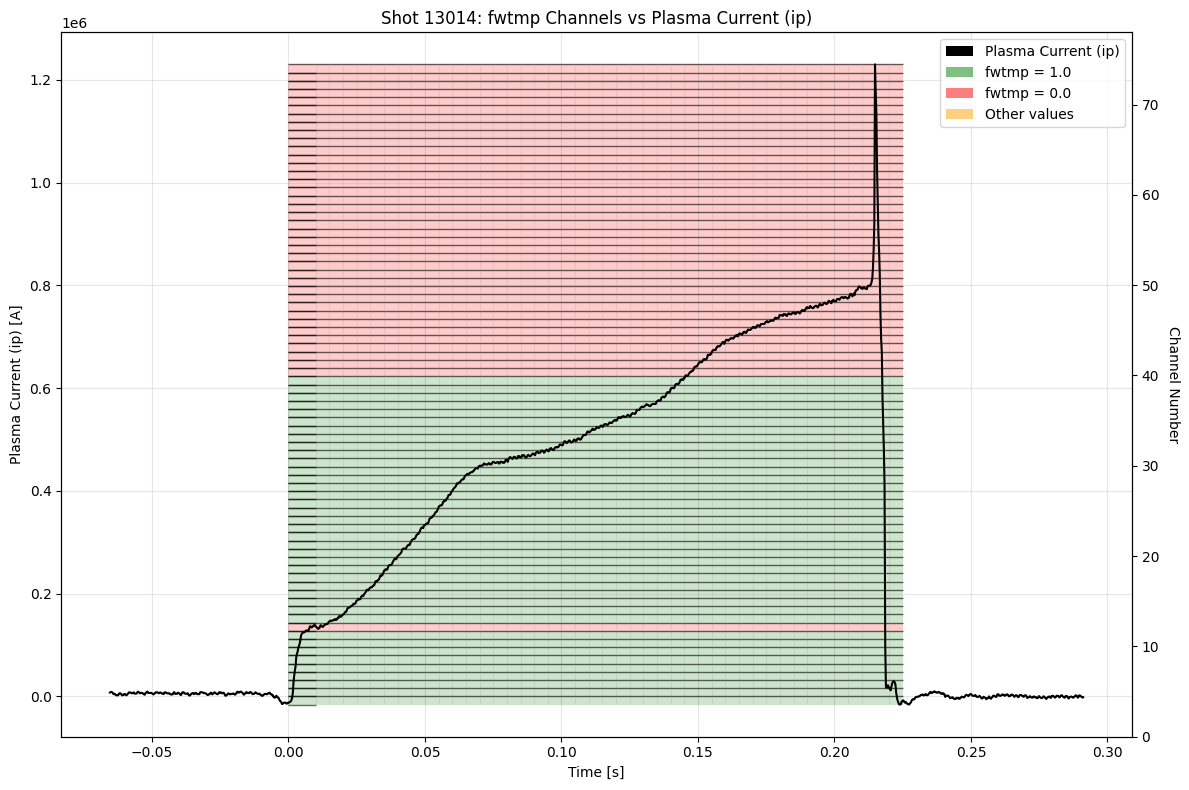

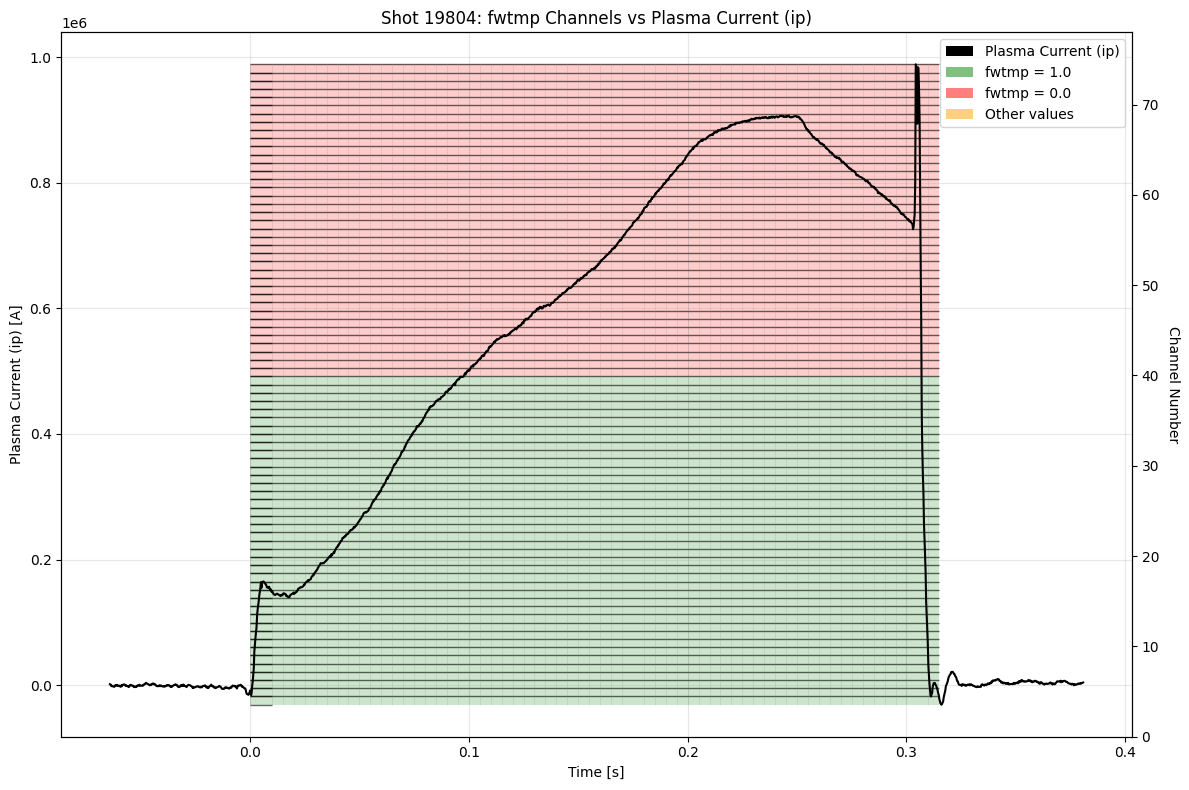

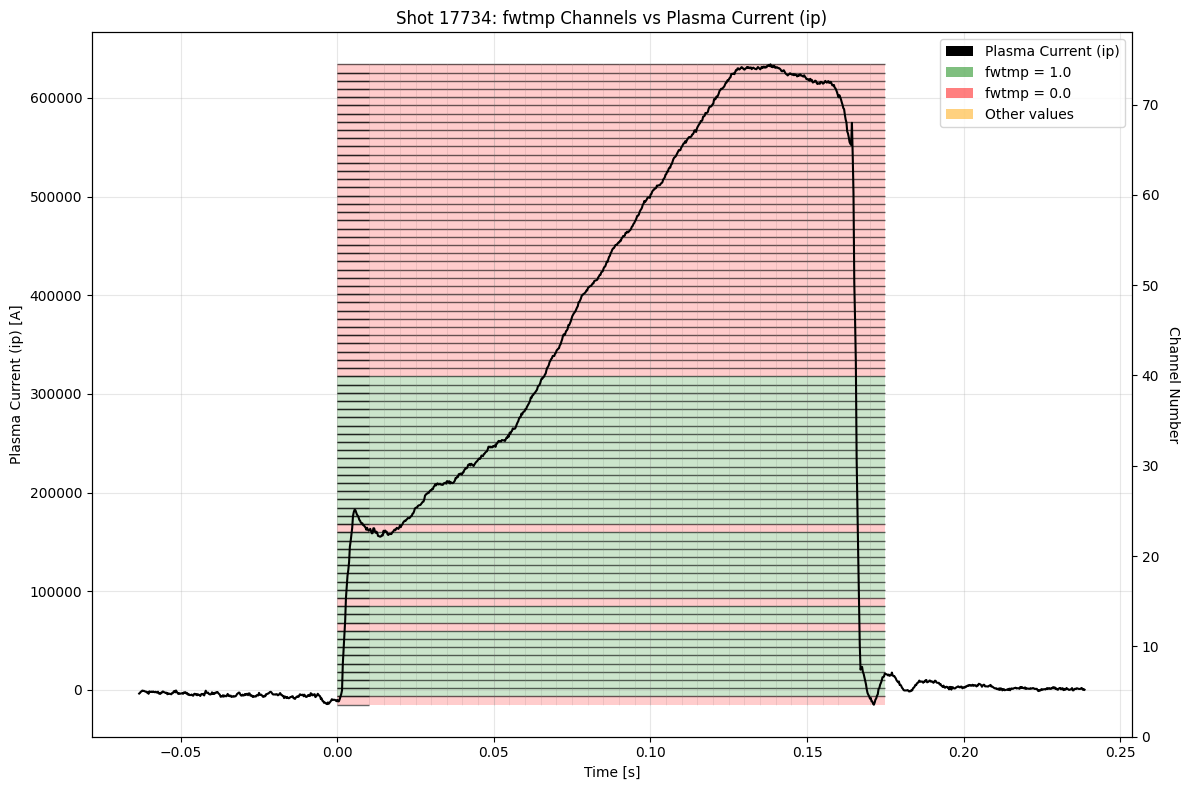

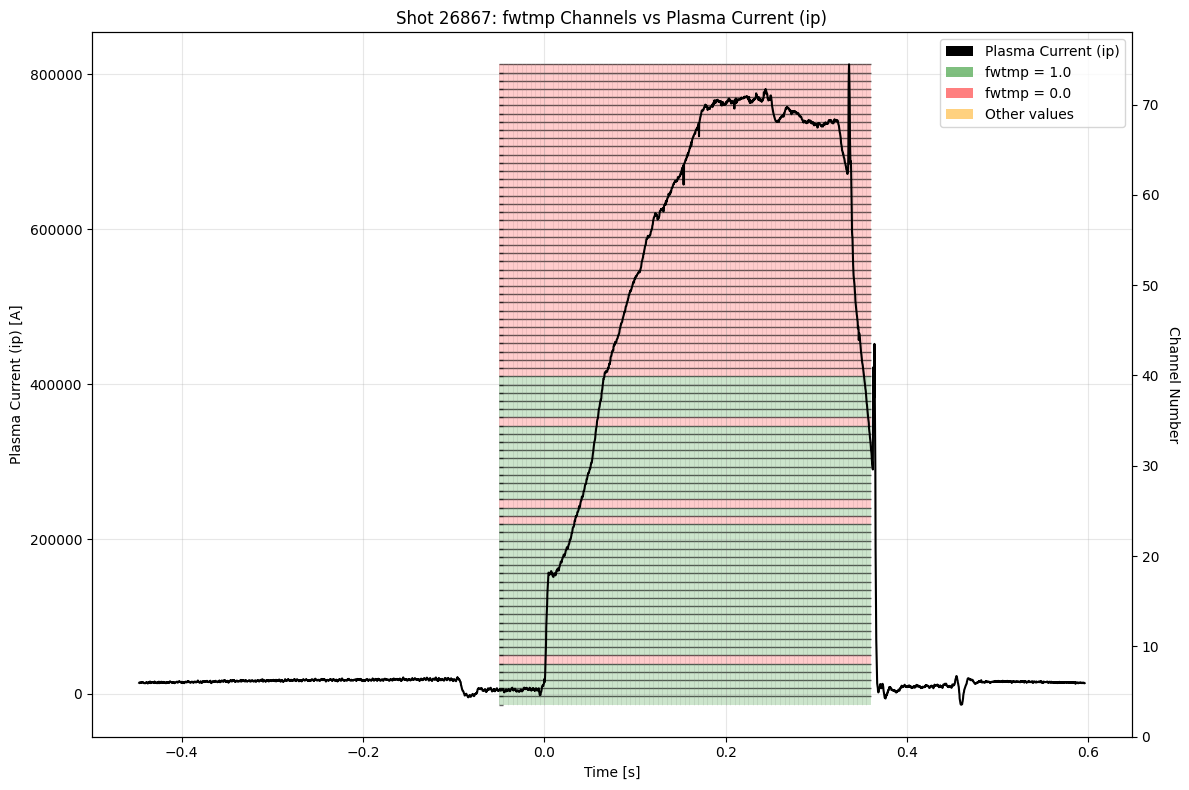

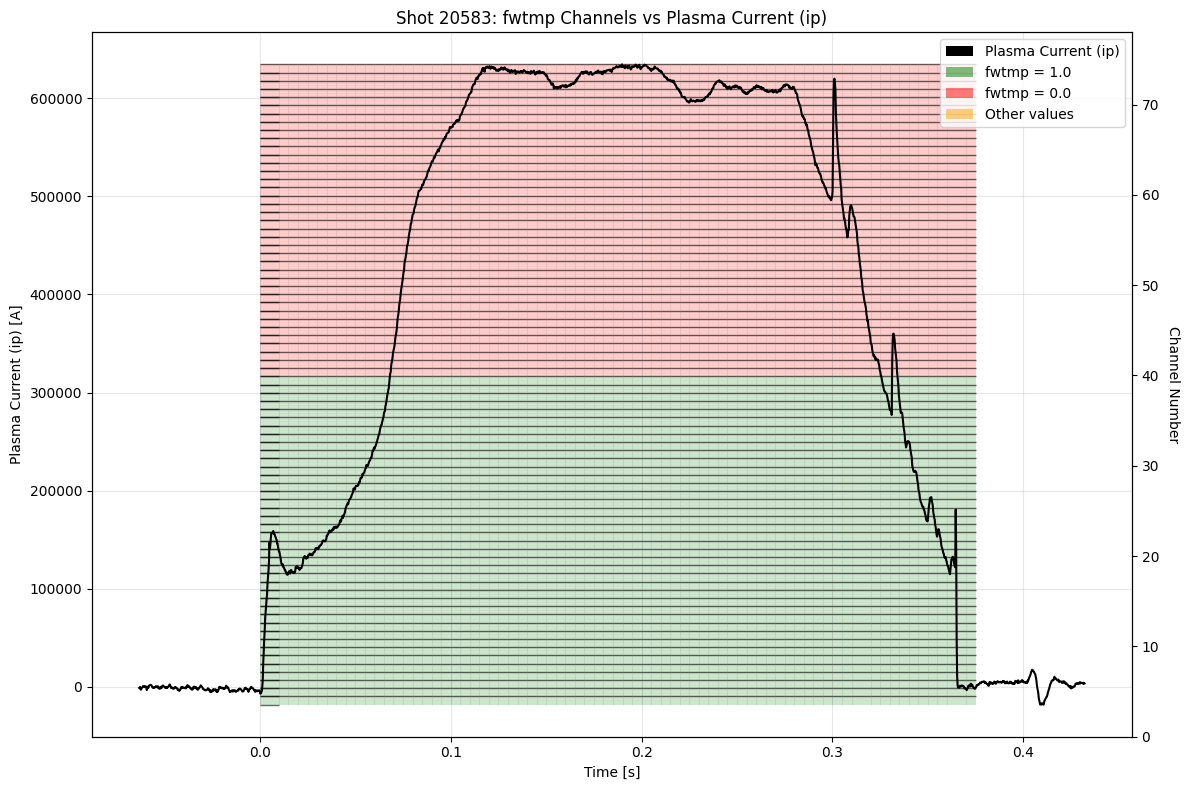

In [ ]:
selected_shots_to_plot = np.random.choice(shot_list, size=10, replace=False)
for shot in selected_shots_to_plot:
    plot_fwtmp_vs_ip(shot, save=False)

## D. Drop in any channel that was 1 at the begining

In [24]:
def process_shot2(shot_id, verbose=False):
    """
    Process a single shot, returning a dictionary of results.

    Parameters
    shot_id: Shot ID to retrieve data for.
    verbose: bool
        Displays messages for debugging or tracking.
    
    Returns
    shot_id: int
        The shot ID processed.
    shot_result: dict
        Dictionary containing the presence of variables and their channels:
    """
    try:
        efm = retry_to_dask(shot_id, group="efm", level=1, verbose=verbose)
        try:
            fwtmp = efm.fwtmp.values
            indices = np.where(np.any(fwtmp == 1.0, axis=0))[0]
            code = []
            for i in indices:
                fwtmp_i = fwtmp[:, i]
                sum_fwtmp_i = np.nansum(fwtmp_i)
                code.append(int(sum_fwtmp_i / len(fwtmp_i)))
            code = int(sum(code) / len(code)) if code else 0
            
        except AttributeError:
            if verbose:
                print(f"No fwtmp data for shot {shot_id}")
            code = 0
            fwtmp = None
    except Exception as e:
        if verbose:
            print(f"Error loading efm data for shot {shot_id}: {e}")
        code = 0
        fwtmp = None
        
    result = {
        "shot_id": shot_id,
        "code": code,
        "fwtmp": fwtmp
    }
    if verbose:
        print(f"Processed shot {shot_id} with code {code}")
    return result


In [25]:
def efit_analysis_parallel2(
    shots: list[int],
    verbose: bool = False,
    max_workers: int = None,
    task_type: str = "cpu"
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers(task_type=task_type)
    print(f"Use of {max_workers} workers (type: {task_type})")

    data_efit = {}

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot2, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_result = future.result()
            data_efit[shot_result["shot_id"]] = shot_result["code"]

    df = pd.DataFrame.from_dict(data_efit, orient="index", columns=["code"])
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [26]:
variable_presence_all = efit_analysis_parallel2(
    shots=shots_with_fwtmp, 
    verbose=False,
    max_workers=None,
    task_type="cpu"
)

Use of 16 workers (type: cpu)


Checking variables (parallel): 100%|██████████| 10781/10781 [40:12<00:00,  4.47it/s]


In [27]:
variable_presence_all

,code
13207,1
12126,1
12123,1
12128,1
12127,1
...,...
30469,1
30467,1
30466,1
30471,1


In [29]:
mask = variable_presence_all['code']==1
shots_with_fwtmp_with_no_changes = variable_presence_all[mask]
shots_with_fwtmp_with_no_changes

,code
13207,1
12126,1
12123,1
12128,1
12127,1
...,...
30469,1
30467,1
30466,1
30471,1


In [28]:
mask = variable_presence_all['code']!=1
shots_with_fwtmp_with_changes = variable_presence_all[mask]
shots_with_fwtmp_with_changes

,code
